# Imports

In [1]:
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
#import shap
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.utils.multiclass import unique_labels
import spacy
import time
from tqdm import tqdm

## Spacy Loading

In [2]:
nlp = spacy.load("en_core_web_sm")

# Data preprocessing

In [3]:
def replace_mentions(text):
    """
    Replaces twitter mentions in the given text by a contant tag.
    Returns the clean text.
    """
    MENTIONS_REPLACEMENT_TAG = "mention"
    MENTIONS_REGEXS = [
        r'(@ [\w\d-]+(( _)|(_ )|( _ )|_)+[\w\d-]+)', # something + _ + something
        r'(@ [\w\d-]+( [\d-]+))', # something + space + numbers
        r'(@ [\w\d-]+)', # something
        ] 

    matches = re.findall('|'.join([f'({regex})' for regex in MENTIONS_REGEXS]), text)
    for tuple_matches in matches:
        if isinstance(tuple_matches, tuple):
            mention = [mention for mention in tuple_matches if len(mention) >= 3][0] # keep the first match which contains at least 3 characters
        else:
            mention = tuple_matches
        text = text.replace(mention, MENTIONS_REPLACEMENT_TAG)
    return text

In [4]:
def replace_hashtags(text):
    """
    Replaces twitter hashtags in the given text by a contant tag.
    Returns the clean text.
    """
    HASHTAGS_REPLACEMENT_TAG = "hashtag"
    HASHTAGS_REGEXS = [
        r'(# [\w\d_-]+( \d+)*)',
        r'(# [\w\d_-]+)',
        ] 

    matches = re.findall('|'.join([f'({regex})' for regex in HASHTAGS_REGEXS]), text)
    for tuple_matches in matches:
        if isinstance(tuple_matches, tuple):
            hashtag = [hashtag for hashtag in tuple_matches if len(hashtag) >= 3][0] # keep the first match which contains at least 3 characters
        else:
            hashtag = tuple_matches
        text = text.replace(hashtag, HASHTAGS_REPLACEMENT_TAG)
    return text

In [5]:
def load_data():
    """
    Loads the data in a pandas' dataframe and group the tweets by author.
    Returns the dataframe containing following columns : 'author_id' (int), 'label' (int) and 'content' (str).
    """
    data = pd.DataFrame()
    data_files = ['./data/AMale.txt', './data/AFemale.txt']

    for data_file in data_files:
        data = data.append(pd.read_csv(data_file, sep="\t", header=None, encoding='latin-1'))

    data = data.drop(1, axis='columns') # drop profile's column (human/bot)
    data = data.rename(columns={0: 'author_id', 2: 'label', 3: 'content'})

    data['author_id'] = data['author_id'].apply(lambda x: int(x)) # ids should be integers
    data['label'] = data['label'].apply(lambda gender: 0 if gender == 'M' else 1) # male:0, female:1
    
    #group data by author
    data = data.groupby(['author_id', 'label'])['content'].apply(lambda content_list : " ".join(content_list)).reset_index(name='content')
    
    return data

In [6]:
def preprocess_data(data):
    """
    Applies preprocessing methods on the given dataframe.
    The dataframe must contain following columns :  'author_id' (int), 'label' (int) and 'content' (str).
    Returns the dataframe.
    """
    # text preprocessing
    data['content'] = data['content'].apply(replace_mentions)
    data['content'] = data['content'].apply(replace_hashtags)
    
    data['original_content'] = data['content'] # original content shouldn't be changed
    
    data['content'] = data['content'].apply(lambda content: content.lower())
    # emojis ?
    # concat tweets of same author ?
    # remove punctuation ?
    # remove stop-words
    # stemming / lemmatization
    
    return data

# Features

In [7]:
def compute_feature_nb_characters(row, feature_name):
    """
    Computes the feature nb_character for the given row.
    Returns the row with the new feature.
    """
    #row[feature_name] = [len(row['content'])]
    #return row
    return len(row['content'])

In [8]:
def compute_feature_nb_word(row, feature_name):
    """
    Computes the feature nb_word for the given row
    Return the row with the new feature.
    """
    doc = nlp(row['content'])
    return len(doc)

In [9]:
def compute_feature_nb_noun(row, feature_name):
    """
    Computes the feature nb_noun for the given row
    Return the row with the new feature.
    """
    doc = nlp(row['content'])
    return len([token for token in doc if token.pos_ == "NOUN"])

In [10]:
def compute_feature_nb_pronoun(row, feature_name):
    """
    Computes the feature nb_pronoun for the given row
    Return the row with the new feature.
    """
    doc = nlp(row['content'])
    return len([token for token in doc if token.pos_ == "PRON"])

In [11]:
def compute_row_features(row, features_dict):
    """
    Computes the features specified in the given dictionary for the given row.
    Returns the row with the new features.
    """
    features = []
    for feature_name, is_feature_used in features_dict.items():
        if is_feature_used:
            if feature_name == 'nb_characters':
                features.append(compute_feature_nb_characters(row, feature_name))
            elif feature_name == 'nb_word':
                features.append(compute_feature_nb_word(row, feature_name))
            elif feature_name == 'nb_noun':
                features.append(compute_feature_nb_noun(row, feature_name))
            elif feature_name == 'nb_pronoun':
                features.append(compute_feature_nb_pronoun(row, feature_name))
    return features

In [12]:
def compute_dataframe_features(data, features_dict):
    """
    Computes the features specified in the given dictionary for the whole dataframe.
    Returns the dataframe with the new features.
    """
    features = []
    for _, row in data.iterrows():
        features.append(compute_row_features(row, features_dict))
    data['features'] = features
    features = np.swapaxes(np.array(features), 0, 1)
    i = 0
    for feature_name, is_feature_used in features_dict.items():
        if is_feature_used:
            data[feature_name] = features[i]
            i += 1
    return data

In [13]:
def scale_data(scaler, X_train, X_test):
    """
    Uses a Scikit-Learn scaler to scale the data.
    Returns the scaled X_train and X_test.
    """
    scaler = scaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

# Classification

In [32]:
def train_model(classifier, X_train, y_train, X_test, y_test, params, pot_confusion_matrix=True):
    """
    Initializes an instance of the given classification model with its parameters.
    Trains and evaluates the classifier before returning it with the classification scores.
    """
    model = classifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores = [accuracy_score(y_test, y_pred), 
              precision_score(y_test, y_pred, average=None), 
              recall_score(y_test, y_pred, average=None)]
    if pot_confusion_matrix:
        plot_confusion_matrix(y_test, y_pred, np.array(['Man', 'Woman']), normalize=True)
    return model, scores

In [31]:
# Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Data visualization

In [16]:
def plot_data(X, y):
    """
    Uses t-SNE to plot an approximation of the data projected in 2d.
    """
    X_embedded = TSNE(n_components=2).fit_transform(X)
    category_to_color = {0: 'cyan', 1: 'magenta'}
    category_to_label = {0: 'Man', 1: 'Woman'}
    
    plt.figure(figsize=(10,10))
    for category in category_to_color.keys():
        plt_x = [X_embedded[i,0] for i, cat in enumerate(y) if cat == category]
        plt_y = [X_embedded[i,1] for i, cat in enumerate(y) if cat == category]
        plt.scatter(plt_x, plt_y, color=category_to_color[category], label=category_to_label[category], alpha=0.6)
        plt.legend(loc='best')
    plt.title('Corpus entries\' visualization')
    plt.show()

# Constants

In [17]:
# define constants here...

# features
features = {
    'nb_characters': True,
    'nb_word' : True,
    'nb_noun' : True,
    'nb_pronoun' : True,
    'nb_tokens': False,
    'nb_big_words': False,
    'nb_lexical_words': False,
}

# models
CLASSIFIER = CatBoostClassifier # [CatBoostClassifier]
SCALER = StandardScaler # [None, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler]

# models' parameters
PARAMS = {
    CatBoostClassifier: {
        'iterations':200, 
        'depth':6, 
        'learning_rate':0.2, 
        'loss_function':'CrossEntropy', 
        'custom_metric':['Accuracy', 'Recall', 'Precision'], 
        'verbose':False},
}
GRIDSEARCH_PARAMS_RANGE = {
    CatBoostClassifier: {
        'loss_function': ['Logloss', 'CrossEntropy'],
        'iterations': [250,100,500,1000],
        'depth': [3,1,2,6,4,5,7,8,9,10],
        'learning_rate': [0.03,0.001,0.01,0.1,0.2,0.3], 
    }
}

# training
NB_CV_SPLITS = 1
GRIDSEARCH_NB_CV_SPLITS = 2
TEST_SIZE = 0.2
PLOT_TRAINING_DATA = False

# ---- constants' validity check
assert NB_CV_SPLITS > 0
assert GRIDSEARCH_NB_CV_SPLITS > 1
assert CLASSIFIER in [CatBoostClassifier]
assert SCALER in [None, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler]
assert TEST_SIZE > 0.0 and TEST_SIZE < 1.0

# Statistics

In [35]:
def display_stats(data):
    """
    Display statistics for 
    - number of word (min/max/avg)
    - number of char (min/max/avg)
    - number of authors
    - number of male/female author
    """
    feature_nb_word = (compute_dataframe_features(data, {'nb_word' : True}) if 'nb_word' not in data.columns else data)['nb_word']
    print(f'Number of words per author. Average : {feature_nb_word.mean()}, Min : {feature_nb_word.min()}, Max : {feature_nb_word.max()}')
    
    feature_nb_characters = (compute_dataframe_features(data, {'nb_characters' : True}) if 'nb_characters' not in data.columns else data)['nb_characters']
    print(f'Number of characters per author. Average : {feature_nb_characters.mean()}, Min : {feature_nb_characters.min()}, Max : {feature_nb_characters.max()}')
     
    print(f'Number of author : {len([x for x in data["label"] if x == 0])}')
    print(f'Number of authoress : {len([x for x in data["label"] if x == 1])}')
    

# Main

In [22]:
data = load_data()
data = preprocess_data(data)
print(data.shape)
data.head()

(2058, 4)


,author_id,label,content,original_content
0,0,1,alex is too nice for love island :( rt mentio...,alex is too nice for love island :( rt mentio...
1,1,1,rt mention : the crypto finance ecosystem by m...,rt mention : the crypto finance ecosystem by m...
2,5,1,mention mention !!!!! mention mention x i fu...,mention mention !!!!! mention mention x i fu...
3,6,0,mention ahaha last time acting reckless ðð...,mention ahaha last time acting reckless ðð...
4,8,1,i ' m so excited for the boojum i ' m about to...,i ' m so excited for the boojum i ' m about to...


In [23]:
data = data
data = compute_dataframe_features(data, features)
X, y = np.array(data['features'].tolist()), np.array(data['label'].tolist())

In [89]:
#data.to_csv("./data/data_first_pos_features.csv")

In [24]:
data.head(5)

,author_id,label,content,original_content,features,nb_characters,nb_word,nb_noun,nb_pronoun
0,0,1,alex is too nice for love island :( rt mentio...,alex is too nice for love island :( rt mentio...,"[6509, 1466, 192, 111]",6509,1466,192,111
1,1,1,rt mention : the crypto finance ecosystem by m...,rt mention : the crypto finance ecosystem by m...,"[11457, 2380, 428, 135]",11457,2380,428,135
2,5,1,mention mention !!!!! mention mention x i fu...,mention mention !!!!! mention mention x i fu...,"[6008, 1341, 204, 105]",6008,1341,204,105
3,6,0,mention ahaha last time acting reckless ðð...,mention ahaha last time acting reckless ðð...,"[5463, 1070, 178, 84]",5463,1070,178,84
4,8,1,i ' m so excited for the boojum i ' m about to...,i ' m so excited for the boojum i ' m about to...,"[8035, 1809, 262, 259]",8035,1809,262,259


In [36]:
display_stats(data)

Number of words per author. Average : 2051.8022351797863, Min : 530, Max : 8140
Number of characters per author. Average : 9716.287172011662, Min : 2375, Max : 36132
Number of author : 1030
Number of authoress : 1028


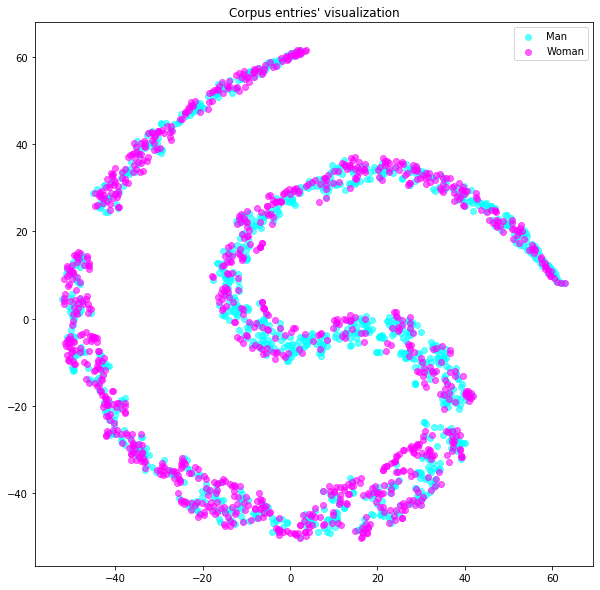

In [26]:
# t-SNE (, Shap)
plot_data(X, y)

In [ ]:
# gridsearch
clf = GridSearchCV(CLASSIFIER(), GRIDSEARCH_PARAMS_RANGE[CLASSIFIER], cv=GRIDSEARCH_NB_CV_SPLITS)
clf.fit(X, y)
print(f'Best classification score: {clf.best_score_}')
print(f'Best parameters: {clf.best_params_}')

Split 1/1
Time to train the classifier: 0.1 m


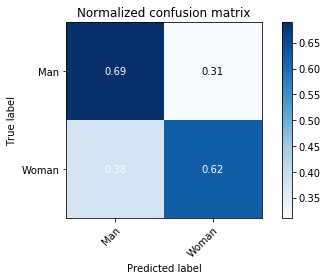

In [33]:
# training
models_and_scores = []
sss = StratifiedShuffleSplit(n_splits=NB_CV_SPLITS, test_size=TEST_SIZE)
start_time = time.time()
for id, (train_index, test_index) in enumerate(sss.split(X, y)):
    print(f'Split {id+1}/{NB_CV_SPLITS}')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # plot training data with t-SNE
    if PLOT_TRAINING_DATA:
        plot_data(X_train, y_train)
    
    # scale
    if SCALER is not None:
        X_train, X_test = scale_data(SCALER, X_train, X_test)
    
    # fit and predict a model
    models_and_scores.append(train_model(CLASSIFIER, X_train, y_train, X_test, y_test, PARAMS[CLASSIFIER]))
print(f'Time to train the classifier: {round((time.time()-start_time)/60, 1)} m')

In [28]:
# metrics
if not isinstance(models_and_scores, pd.DataFrame):
    models_and_scores = pd.DataFrame(models_and_scores, columns=['Model', 'Scores'])
    models_and_scores['Accuracy'] = models_and_scores['Scores'].apply(lambda scores: scores[0])
    models_and_scores['Precision'] = models_and_scores['Scores'].apply(lambda scores: scores[1])
    models_and_scores['Recall'] = models_and_scores['Scores'].apply(lambda scores: scores[2])
    models_and_scores = models_and_scores.drop('Scores', axis='columns')

print('Mean accuracy: {:.3f}'.format(models_and_scores["Accuracy"].mean()))

Mean accuracy: 0.643
